# Sequential Model
\
Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential

Import and explore the data


3264


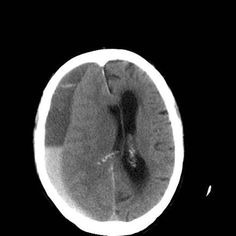

In [2]:
import pathlib
dataset_url = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_images'
data_dir = pathlib.Path(dataset_url)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
PIL.Image.open(str(list(data_dir.glob('no_tumor/*'))[0]))

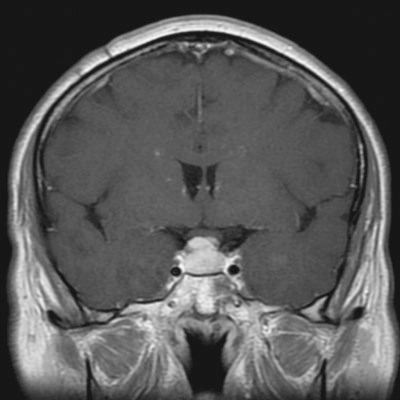

In [3]:
PIL.Image.open(str(list(data_dir.glob('pituitary_tumor/*'))[0]))

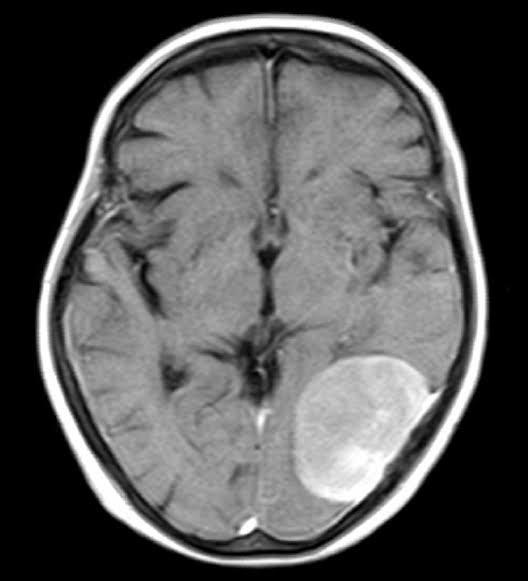

In [4]:
PIL.Image.open(str(list(data_dir.glob('meningioma_tumor/*'))[0]))

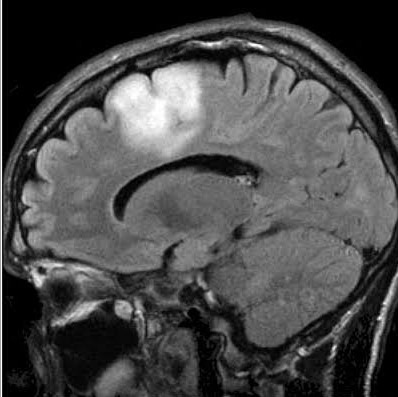

In [5]:
PIL.Image.open(str(list(data_dir.glob('glioma_tumor/*'))[0]))

Create a dataset and split into train/test

In [6]:
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3264 files belonging to 4 classes.
Using 2612 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3264 files belonging to 4 classes.
Using 652 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


Visualize the training data

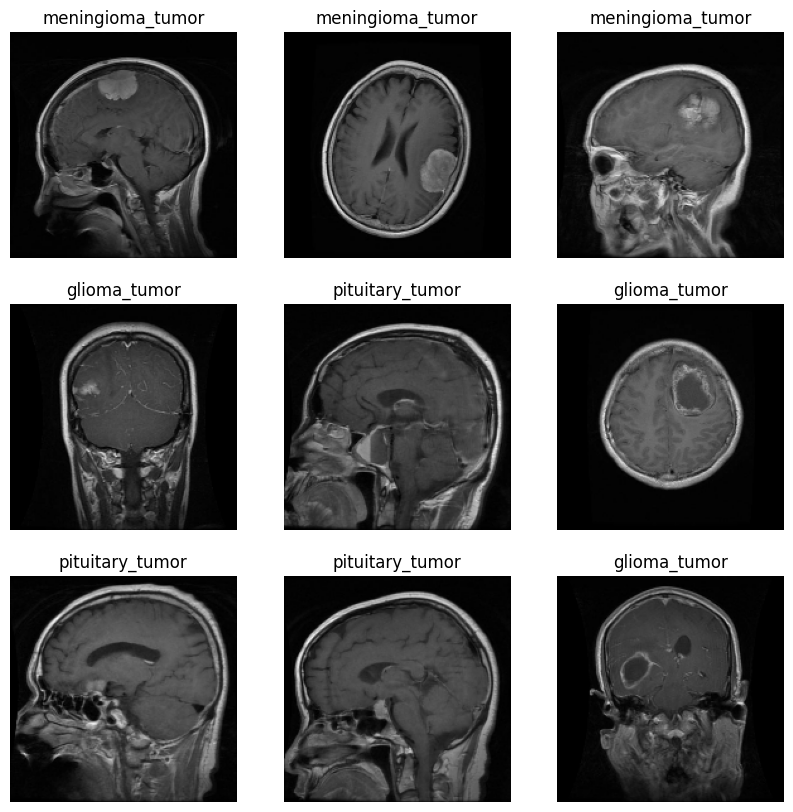

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data: convert RGB channels in the [0, 255] range to [0, 1]

In [11]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.93792206


Create a sequential model

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the model

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

View the layers of the model using the summary method

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Train the model for 10 epochs

In [15]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
82/82 [==============================] - 15s 87ms/step - loss: 1.0124 - accuracy: 0.5727 - val_loss: 0.7153 - val_accuracy: 0.7255
Epoch 2/10
82/82 [==============================] - 2s 22ms/step - loss: 0.5513 - accuracy: 0.7856 - val_loss: 0.4932 - val_accuracy: 0.8175
Epoch 3/10
82/82 [==============================] - 2s 23ms/step - loss: 0.3190 - accuracy: 0.8867 - val_loss: 0.6017 - val_accuracy: 0.7469
Epoch 4/10
82/82 [==============================] - 2s 24ms/step - loss: 0.2330 - accuracy: 0.9177 - val_loss: 0.5054 - val_accuracy: 0.8190
Epoch 5/10
82/82 [==============================] - 2s 21ms/step - loss: 0.1193 - accuracy: 0.9594 - val_loss: 0.5263 - val_accuracy: 0.8390
Epoch 6/10
82/82 [==============================] - 2s 21ms/step - loss: 0.0587 - accuracy: 0.9812 - val_loss: 0.4057 - val_accuracy: 0.8819
Epoch 7/10
82/82 [==============================] - 2s 21ms/step - loss: 0.0261 - accuracy: 0.9927 - val_loss: 0.6286 - val_accuracy: 0.8850
Epoch 8/10
8

Visualize training results using plots of loss and accuracy on the training and validation sets

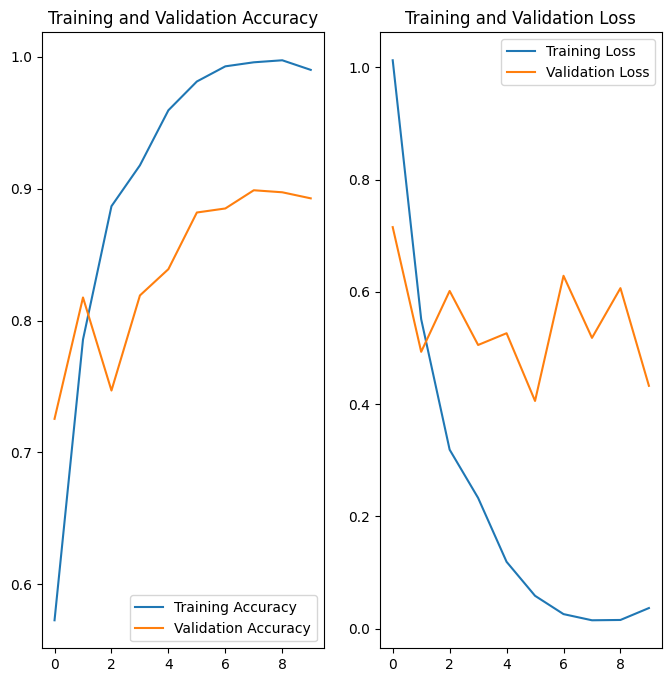

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Overfitting seen from the difference between training and validation accuracy
\
\
Adding data augmentation to reduce overfitting: random flipping, rotation, and zoom

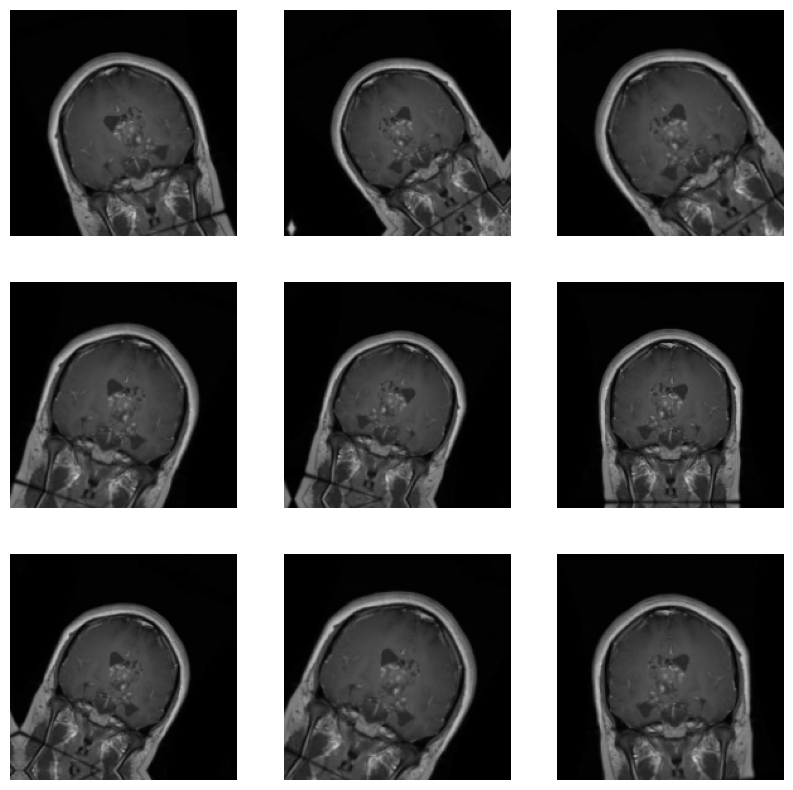

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Adding dropout to reduce overfitting: randomly dropping 20% of the output from the last pooling layer

In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

Compile and train the new model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [20]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
82/82 [==============================] - 6s 32ms/step - loss: 1.2148 - accuracy: 0.4502 - val_loss: 0.8868 - val_accuracy: 0.6396
Epoch 2/10
82/82 [==============================] - 2s 30ms/step - loss: 0.9606 - accuracy: 0.5892 - val_loss: 0.7493 - val_accuracy: 0.6656
Epoch 3/10
82/82 [==============================] - 2s 30ms/step - loss: 0.8352 - accuracy: 0.6386 - val_loss: 0.6795 - val_accuracy: 0.7117
Epoch 4/10
82/82 [==============================] - 3s 32ms/step - loss: 0.7704 - accuracy: 0.6822 - val_loss: 0.6373 - val_accuracy: 0.7255
Epoch 5/10
82/82 [==============================] - 3s 33ms/step - loss: 0.7179 - accuracy: 0.7148 - val_loss: 0.5788 - val_accuracy: 0.7485
Epoch 6/10
82/82 [==============================] - 3s 31ms/step - loss: 0.6423 - accuracy: 0.7312 - val_loss: 0.6822 - val_accuracy: 0.7485
Epoch 7/10
82/82 [==============================] - 2s 29ms/step - loss: 0.6468 - accuracy: 0.7366 - val_loss: 0.6822 - val_accuracy: 0.7393
Epoch 8/10
82

Visualize training results: more aligned accuracies

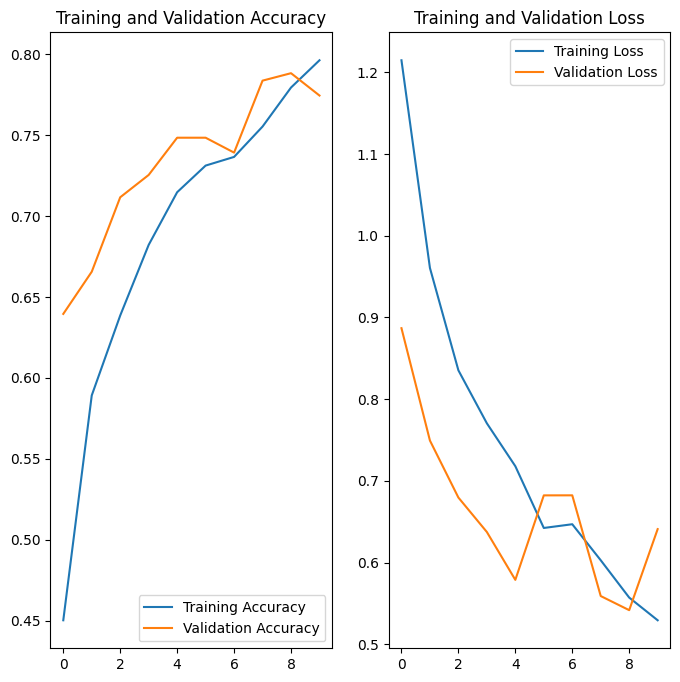

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# CNN
\
Recreate new train and test data

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dataset_url,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    dataset_url,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 2612 images belonging to 4 classes.
Found 652 images belonging to 4 classes.


Create the model

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 107584)           

Optimize and train (slow performance?)

In [24]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
        train_generator, 
        steps_per_epoch = train_generator.samples // batch_size,  
        validation_data = validation_generator,
        validation_steps = validation_generator.samples // batch_size,
        epochs=epochs)

Epoch 1/10
81/81 [==============================] - 49s 578ms/step - loss: 1.2190 - accuracy: 0.4492 - val_loss: 1.1976 - val_accuracy: 0.4062
Epoch 2/10
81/81 [==============================] - 45s 555ms/step - loss: 0.9856 - accuracy: 0.6109 - val_loss: 1.1245 - val_accuracy: 0.4891
Epoch 3/10
81/81 [==============================] - 44s 544ms/step - loss: 0.8028 - accuracy: 0.6818 - val_loss: 1.0533 - val_accuracy: 0.5094
Epoch 4/10
81/81 [==============================] - 44s 539ms/step - loss: 0.7380 - accuracy: 0.7058 - val_loss: 1.0887 - val_accuracy: 0.5188
Epoch 5/10
81/81 [==============================] - 44s 540ms/step - loss: 0.6234 - accuracy: 0.7450 - val_loss: 1.0113 - val_accuracy: 0.5781
Epoch 6/10
81/81 [==============================] - 44s 546ms/step - loss: 0.5704 - accuracy: 0.7740 - val_loss: 1.0182 - val_accuracy: 0.5594
Epoch 7/10
81/81 [==============================] - 42s 526ms/step - loss: 0.5162 - accuracy: 0.7919 - val_loss: 0.9998 - val_accuracy: 0.6078

Visualize training results

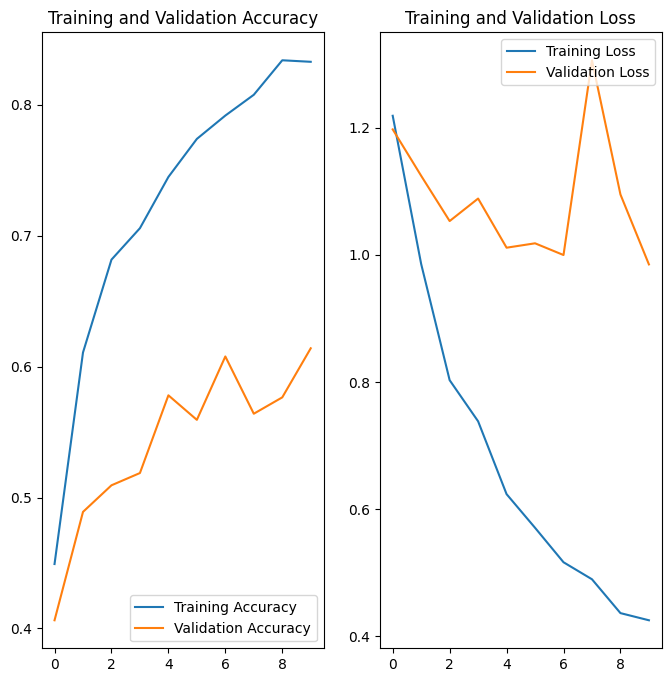

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Transfer learning
\
Recreate new train and test data


In [86]:
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
  dataset_url,
  shuffle=True,
  seed=321,
  image_size=IMG_SIZE,
  batch_size=batch_size)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  dataset_url,
  shuffle=True,
  seed=321,
  image_size=IMG_SIZE,
  batch_size=batch_size)

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Found 3264 files belonging to 4 classes.
Found 3264 files belonging to 4 classes.
Number of validation batches: 82
Number of test batches: 20


Configure the dataset for performance

In [76]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Add data augmentation

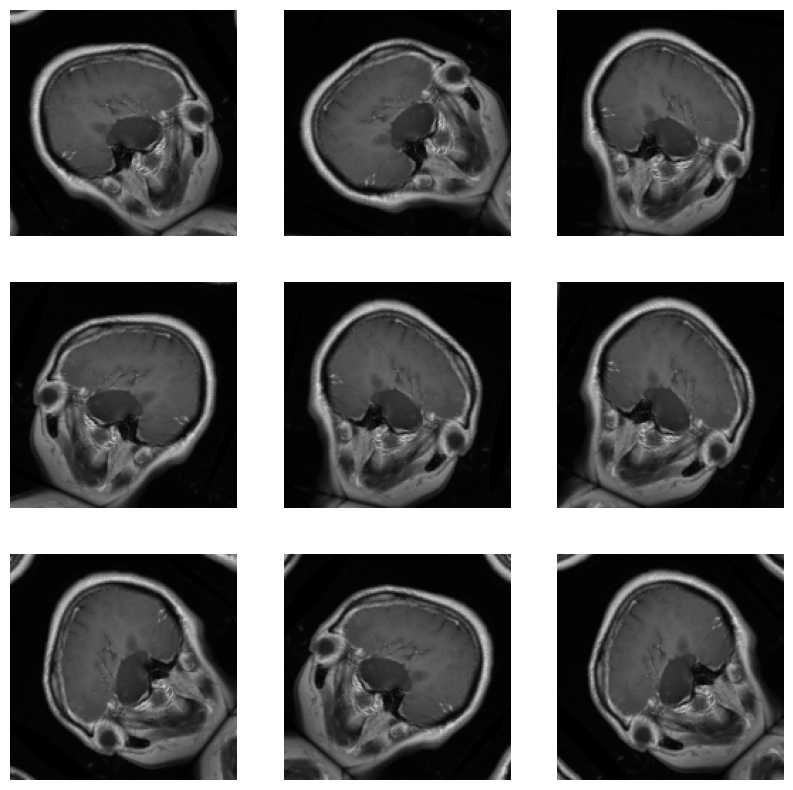

In [77]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Rescale pixel values for the MobileNet V2 base model which expects [-1, 1] pixel values

In [78]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Instantiate base model for feature extraction

In [79]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

9406464/9406464 [==============================] - 1s 0us/step
(32, 5, 5, 1280)


Feature extraction

In [94]:
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

(32, 1280)
(32, 4)


Compile the model

In [102]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, None, None, 3)     0         
                                                                 
 tf.math.truediv_8 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_8 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [103]:
print(len(model.trainable_variables))
loss0, accuracy0 = model.evaluate(validation_dataset)

2
82/82 [==============================] - 10s 73ms/step - loss: 1.0553 - accuracy: 0.5705


Train the model

In [104]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/10
102/102 [==============================] - 20s 164ms/step - loss: 1.0644 - accuracy: 0.5551 - val_loss: 0.9097 - val_accuracy: 0.6319
Epoch 2/10
102/102 [==============================] - 25s 240ms/step - loss: 0.9329 - accuracy: 0.6189 - val_loss: 0.8217 - val_accuracy: 0.6711
Epoch 3/10
102/102 [==============================] - 17s 161ms/step - loss: 0.8546 - accuracy: 0.6566 - val_loss: 0.7567 - val_accuracy: 0.7050
Epoch 4/10
102/102 [==============================] - 17s 162ms/step - loss: 0.8029 - accuracy: 0.6814 - val_loss: 0.7130 - val_accuracy: 0.7214
Epoch 5/10
102/102 [==============================] - 17s 164ms/step - loss: 0.7648 - accuracy: 0.7019 - val_loss: 0.6912 - val_accuracy: 0.7302
Epoch 6/10
102/102 [==============================] - 17s 163ms/step - loss: 0.7158 - accuracy: 0.7230 - val_loss: 0.6675 - val_accuracy: 0.7317
Epoch 7/10
102/102 [==============================] - 20s 194ms/step - loss: 0.6990 - accuracy: 0.7276 - val_loss: 0.6487 - val_ac

Plot the learning curves

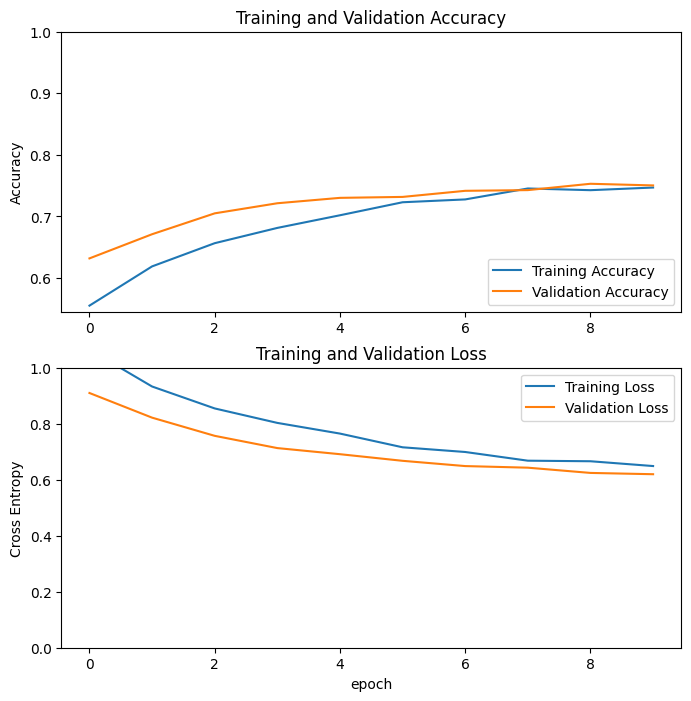

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine tuning

In [106]:
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Compile the model

In [107]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, None, None, 3)     0         
                                                                 
 tf.math.truediv_8 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_8 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

Continue training the model

In [108]:
history_fine = model.fit(train_dataset,
                         epochs=(epochs+10),
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
102/102 [==============================] - 103s 886ms/step - loss: 0.6020 - accuracy: 0.7656 - val_loss: 0.4824 - val_accuracy: 0.8136
Epoch 11/20
102/102 [==============================] - 17s 165ms/step - loss: 0.5097 - accuracy: 0.8067 - val_loss: 0.4198 - val_accuracy: 0.8438
Epoch 12/20
102/102 [==============================] - 17s 167ms/step - loss: 0.4513 - accuracy: 0.8309 - val_loss: 0.4305 - val_accuracy: 0.8335
Epoch 13/20
102/102 [==============================] - 18s 170ms/step - loss: 0.4140 - accuracy: 0.8428 - val_loss: 0.3557 - val_accuracy: 0.8628
Epoch 14/20
102/102 [==============================] - 21s 201ms/step - loss: 0.3810 - accuracy: 0.8591 - val_loss: 0.3501 - val_accuracy: 0.8636
Epoch 15/20
102/102 [==============================] - 17s 166ms/step - loss: 0.3417 - accuracy: 0.8732 - val_loss: 0.3513 - val_accuracy: 0.8678
Epoch 16/20
102/102 [==============================] - 17s 167ms/step - loss: 0.3246 - accuracy: 0.8863 - val_loss: 0.3878 

Plot the training results

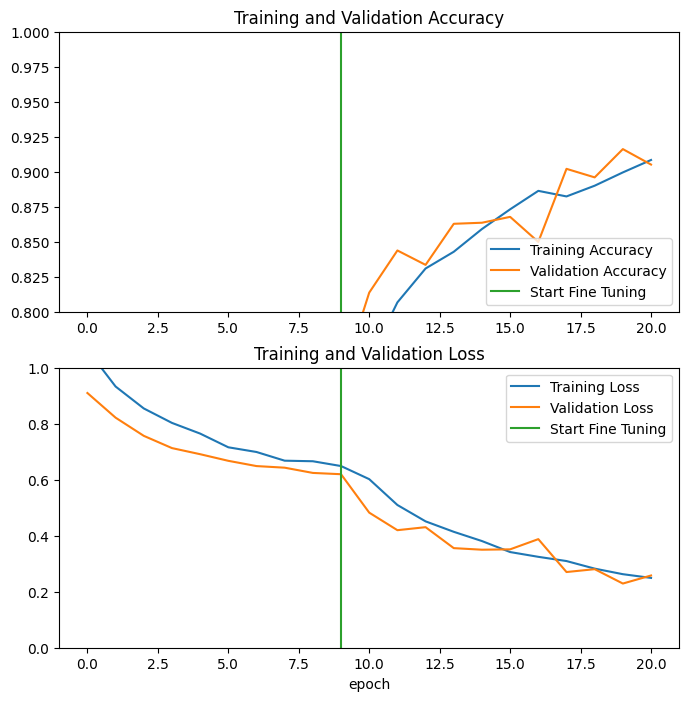

In [109]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predict on test set

In [110]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

20/20 [==============================] - 2s 80ms/step - loss: 0.2808 - accuracy: 0.8953
Test accuracy : 0.895312488079071


## Analysis
\
The final accuracies were 0.80 for sequential, 0.83 for CNN, and 0.90 for transfer learning. After getting transfer learning to work, I think it's the model best suited for this particular dataset. After feature extraction, its accuracy was about 0.75, but after fine tuning, it beat sequential and CNN. The sequential model overfit very easily, but this overfitting was as easy to reduce using data augmentation and dropoff layers. CNN was by far the worst in terms of its runtime - it took a little more than 10 minutes to train because I wasn't able to find a way to configure the data for performance. The main issue with this was because I couldn't find a way to separate all of the data into the format of train_images, train_labels, test_images, and train_images, and was instead forced to use generators with the model.